## Group 27

In [1]:
%matplotlib inline  
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib3
import urllib.parse
import urllib.request
from urllib.parse import quote, unquote
from urllib.request import urlopen
import regex as re
import json

# Part 1: Exploring the friendship paradox. 

This first part draws on the friendship paradox exercise from Week 3. You should provide solutions to the following exercises from **Part 3** of that week.

* *The friendship paradox in BA networks*
* *The friendship paradox more generally*
* *The friendship paradox and the configuration model*
* *Growth without preferential attachment*

In [4]:
# graph with 1 link
FBA = nx.Graph()
FBA.add_edge(1, 2)

# new node
# we can select a node at random and connect it to the new node as both 1 and 2 have the same probability of being selected (same degree)
FBA.add_edge(1, 3)

while FBA.number_of_nodes() < 5000:
    # create a list of all edges
    nodes = list(FBA.nodes())   
    # flatten the list of edges to remove connection information 
    nodes = [node for node in nodes for _ in range(FBA.degree[node])]
    # randomly select a node
    connect_to = np.random.choice(nodes)
    # add a new node
    FBA.add_edge(FBA.number_of_nodes()+1, connect_to)

### The friendship paradox in BA networks
> * Pick a node $i$ at random (e.g. use `random.choice`). [Find its degree](https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.Graph.degree.html).

In [11]:
i = np.random.choice(list(FBA.nodes()))
degree_i = FBA.degree(i)
print("Degree of node ", i,": ", degree_i)

Degree of node  127 :  4



> * Find $i$'s [neighbors](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.Graph.neighbors.html?highlight=neighbors#networkx.Graph.neighbors). And calculate their average degree.


In [12]:
i_neig = list(FBA.neighbors(i)) 
average_neig = np.mean([FBA.degree(neig) for neig in i_neig])
print("Neighbors of node ", i, " are ", i_neig)
print("Their average degree is ", average_neig)


Neighbors of node  127  are  [16, 322, 1567, 2616]
Their average degree is  16.5



> * Compare the two numbers to check if it's true that $i$'s friends (on average) have more friends than $i$.

In [13]:
print("Average degree of i's neighbors > Degree of node i?", average_neig > FBA.degree(i))

Average degree of i's neighbors > Degree of node i? True



> * Do this 1000 times. How many out of those 1000 times is the friendship paradox true in **F-BA**?

In [40]:
FBA_friendship_paradox = 0
for j in range(1000):
    i = np.random.choice(list(FBA.nodes()))
    i_neig = list(FBA.neighbors(i))
    average_neig = np.mean([FBA.degree(neig) for neig in i_neig])
    if average_neig > FBA.degree(i):
        FBA_friendship_paradox += 1
print("Number of times the friendship paradox holds: ", FBA_friendship_paradox)

Number of times the friendship paradox holds:  854


The Friendship Paradox states that, on average, most people have fewer friends than their friends, which seems contradictory, but is a natural result of networks with a power law degree distribution. In these networks, a few ‘central’ nodes with very high degrees significantly increase the average degree of their neighbours. As most nodes are connected to these hubs, their friends tend to have more connections, making the paradox true in a large majority of cases, as confirmed by the simulation.


### The friendship paradox more generally
> * What if the power law is flatter, e.g. $p(k) \sim k^{-\gamma}$ with $\gamma = 2$? Will the fraction of times the paradox is true be higher or lower? 
>   - First answer this question by simply reasoning. Think about what it would mean in terms of hubs that the power law is flatter?

In a network with a flatter power law we would have more nodes with a higher degree, leading to a greater number of hubs. Thus, the number of times the Friendship Paradox holds will most likely be higher, as the presence of more hubs increases the chances of a randomly chosen node being connected to higher-degree nodes. This raises its neighbors' average degree, often making it higher than the degree of the node itself (even for nodes that are hubs).


>   - Now simulate a new network with the slope mentioned above. You can generate networks with power-law degree distributions using the [configuation model](https://en.wikipedia.org/wiki/Configuration_model). The `networkx` funtion is here [`nx.configuration_model`](https://networkx.org/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html). I suggest you make the network pretty big ... let's say 5000 nodes or more.
>     * Hint 0: In the `networkx` function mentioned above, you need a degree sequence. This can be created using the so-called transformation method. If we can generate a random real number $r$ uniformly distributed in the range $0 \leq r < 1$, then $x = x_{\textrm{min}}(1 – r)^{-1/\alpha - 1}$ is a random power-law-distributed real number in the range $x_{\textrm{min}} \leq x < \infty$ with exponent $\alpha$. Note that there has to be a lower limit $x_\textrm{min}$ on the range; the power-law distribution diverges as $x\rightarrow 0$. See [this paper](https://www.cs.cornell.edu/courses/cs6241/2019sp/readings/Newman-2005-distributions.pdf) for more details.
>     * Hint 1: The sequence generated using the method mentioned above consists of real numbers, we need integers, so it needs to be rounded as well.
>     * Hint 2: Also, due to some details of how the configuation works (see the [wiki page](https://en.wikipedia.org/wiki/Configuration_model) for details), the sequence cannot have a sum which is an odd number, so if your sequence turns out odd, just choose an element and add 1 to its degree, that way the sum will be an even number.

In [41]:
# create degree sequence (transformation method)
def degree_sequence(n, gamma, x_min):
    # generate n random real numbers uniformly distributed in the range 0 ≤ r < 1
    r = np.random.rand(n)
    # generate a random power-law-distributed real number
    sequence = np.ceil(x_min * (1 - r)**(-1/gamma - 1))
    # transform the real numbers into integers
    sequence = sequence.astype(int)
    # confirm sequence sums up to an even number
    if sum(sequence) % 2 != 0:
        sequence[-1] += 1
    return sequence

sequence_H = degree_sequence(5000, 2, 1)


In [42]:
# generate power-law degree distributed graph
H = nx.configuration_model(sequence_H)

H_friendship_paradox = 0
for j in range(1000):
    i = np.random.choice(list(H.nodes()))
    i_neig = list(H.neighbors(i))
    average_neig = np.mean([H.degree(neig) for neig in i_neig])
    if average_neig > H.degree(i):
        H_friendship_paradox += 1
print("Number of times the friendship paradox holds: ", H_friendship_paradox)


Number of times the friendship paradox holds:  999



> - Did you reason correctly above? For what fraction of the time is the friendship paradox true for your network with a new slope?

Yes, the Friendship Paradox proved to be true for a higher fraction of the time for the network with the new slope compared to the F-BA network.


In [43]:
print("The paradox holds\n", H_friendship_paradox/10, "% of the time or the new slope\n and ", FBA_friendship_paradox/10,"% for the F-BA network")

The paradox holds
 99.9 % of the time or the new slope
 and  85.4 % for the F-BA network


### The friendship paradox and the configuration model

> - Now generate a network for the configuration model that has *the same slope and number of nodes as **F-BA** in A above*; let's call this new network **F-CM** (for *friendship configuration model*). 

In [44]:
# using F-BA's degree sequence to generate F-CM ensures they have the same degree distribution, thus slope, and number of nodes
degrees_FCM = [FBA.degree(node) for node in FBA.nodes()]
FCM = nx.configuration_model(degrees_FCM)


>    - What fraction of the time is the friendship paradox is true for the **F-CM** network?

In [45]:
FCM_friendship_paradox = 0
for j in range(1000):
    i = np.random.choice(list(FCM.nodes()))
    i_neig = list(FCM.neighbors(i))
    average_neig = np.mean([FCM.degree(neig) for neig in i_neig])
    if average_neig > FCM.degree(i):
        FCM_friendship_paradox += 1
print("Number of times the friendship paradox holds: ", FCM_friendship_paradox)

Number of times the friendship paradox holds:  615



>    - Assuming that **F-BA** and **F-CM** have the same degree sequence can now *think* about if **F-BA** and **F-CM** are different with respect to the friendship paradox. Specifically, please explain your thoughts on the following topics
>       * Are there factors beyond the degree-distribution that could impact how frequently the friendship paradox is true? I might consider how network properties like assortativity, clustering, community-structure, etc potentially could impact things (it's OK to search online and add references to your answer).

While both F-BA and F-CM networks have the same degree distribution, other network properties such as assortativity, clustering, community structure, and path length can impact how frequently the friendship paradox occurs. 

F-BA networks tend to be **disassortative**, meaning high-degree nodes often connect with low-degree ones, which enhances the paradox, as a low-degree node is more likely to be connected to a highly connected node thus raising its' neighbors average degree. 
F-CM are typically **degree-neutral**, reducing the contrast between high and low-degree nodes and the frequency of the friendship paradox. 

At the same time F-BA models usually have **lower clustering** coefficients and **less community-structure**, as their preferencial-attachment mechanism does not form tight groups. This reduces the likelihood of neighbors of a node being connected to each other, making the paradox hold more frequently. On the other hand, in F-CM, clustering and community structure can **vary** depending on the degree sequence and configuration, making it possible for a network to be **more clustered** and consequently reducing the paradox, as neighbors of a node would have similar degrees.  

The **shorter average path lengths** of F-BA network related to the existence of extreme hubs (small-world effect) may also contribute to a more frequent occurrence of the paradox, because it is easier to find a node connected to a high-degree neighbor. F-CM, where there are typically **longer path lengths**, present less connectivity between nodes, lowering the occurrence of the paradox.

In conclusion, F-BA's lower assortativity, clustering and shorter paths tend to increase the frequency of the friendship paradox.

*References:* 

Barabási, A. L. (2012), *Network Science*. Cambridge University Press.

Fortunato, S. (2010). *Community detection in graphs*. Physics Reports Journal.

Newman, M. E. J. (2002). *Assortative mixing in networks*. Physical Review Letters.


>       * How would you test more rigorously if the friendship-paradox is actually true equally often in **F-BA** and **F-CM**? (E.g. how would you run a statistical test to investigate ... or how would you put error-bars on your plots?).

To test rigorously the friendship paradox in F-BA and F-CM networks, firstly it would be necessery to simulate many instances of both network models, randomly select nodes, and check how often the paradox holds. 
Then calculate the empirical frequency of the paradox in each model by dividing the number of instances where the paradox is observed by the total number of nodes checked and compute confidence intervals for these proportions using binomial proportion intervals. To formally compare the frequencies, a z-test for two proportions can be used to test if the occurrence rates differ significantly. Finally, visualize the results with error bars representing the confidence intervals for both F-BA and F-CM.


### Growth without preferential attachment

> Finally, we'll build a network of same size and degree as in the exercise above, *using the growth mechanism without the preferential attachment*. Follow the steps below for success
> 
>  1. Grow a new network (the Sune-network) with the same parameters as the **F-BA** network in the exercise above, i.e. 5000 nodes, each new node connects to the existing network, but with one key difference: *have the incoming nodes connect to the existing nodes with* **equal probability**. This is the Sune-network.

In [46]:
Sune = nx.Graph()
Sune.add_edge(1, 2)

while Sune.number_of_nodes() < 5000:
    # list of all edges
    # new nodes connect to existing nodees with equal probability so we only need to consider the nodes
    nodes = list(Sune.nodes())   
    # randomly select a node
    connect_to = np.random.choice(nodes)
    # add a new node
    Sune.add_edge(Sune.number_of_nodes()+1, connect_to)



>  2. Generate an ER network of same number of nodes and links as the Sune-network. 


In [47]:
num_nodes = Sune.number_of_nodes()
num_edges = Sune.number_of_edges()
ER = nx.gnm_random_graph(num_nodes, num_edges)


> * What are the differences between the ER network and the Sune-network? Explain in your own words. 
>   * *Hints*: To get started, plot the two degree distribution in the same plot. Compare and contrast. Another revealing network property to study is the the number of connected components.


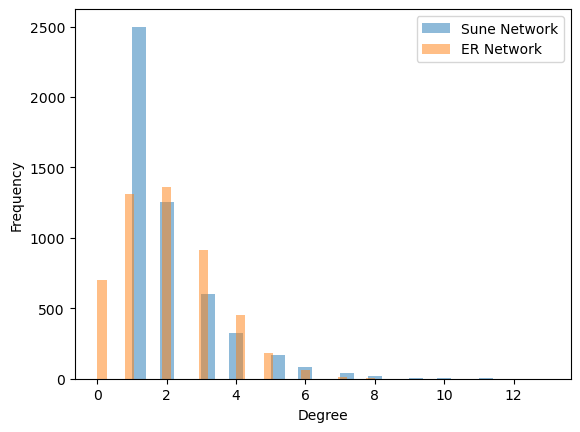

In [48]:
# plot degree distributions
sune_degrees = [d for n, d in Sune.degree()]
er_degrees = [d for n, d in ER.degree()]

plt.hist(sune_degrees, bins=30, alpha=0.5, label="Sune Network")
plt.hist(er_degrees, bins=30, alpha=0.5, label="ER Network")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [49]:
# Compare connected components
print(f"Sune-network connected components: {nx.number_connected_components(Sune)}")
print(f"ER-network connected components: {nx.number_connected_components(ER)}")

Sune-network connected components: 1
ER-network connected components: 829


The Sune network, where each new node connects to a single existing node, has a narrower distribution, resulting in most nodes having similar degrees and forming a single large connected component. In contrast, the ER network has a more varied distribution with a broader spread of degrees, including higher frequencies of nodes with degrees 2, 3, and 4, reflecting the random edge assignment that creates an ER model. Comparing both networks, the ER network shows a greater diversity of node degrees, with a smoother distribution across higher degrees compared to the Sune network, which leads to multiple connected components. This demonstrates that the ER network has a more diverse range of node degrees, while the Sune network is more tightly clustered around nodes with very few connections.

# Part 2: Stats of the Country Music Network

This second part requires you to have built the network of Country Musicians as described in the exercises for Week 4. You should complete the following exercise from **Part 2**.

* *Simple network statistics and analysis*

And the following exercise from **Part 3**

* *Let's build a simple visualization of the network*

And that's it! You're all set.

In [2]:
response = urlopen("https://en.wikipedia.org/wiki/List_of_country_music_performers")
html = response.read()

In [3]:

base_url = "https://en.wikipedia.org/w/api.php"
params = {
    "action": "query",
    "titles": "List_of_country_music_performers",
    "prop": "revisions",
    "rvprop": "content",
    "format": "json"
}

# Construct the query URL by encoding the parameters
encoded_params = urllib.parse.urlencode(params)
query_url = f"{base_url}?{encoded_params}"

In [4]:
wikiresponse = urlopen(query_url)
wikisource = wikiresponse.read()
wikijson = json.loads(wikisource)
pages = wikijson["query"]["pages"]

In [5]:
# Loop through the pages     
for page_id, page in pages.items():
    # Get the wikitext from the page
    wikitext = page.get("revisions", [{}])[0].get("*", "")
    # Extract everything after {{Dynamic list}} in the page
    artists_list = re.search(r'\{\{Dynamic list\}\}(.*)', wikitext, re.DOTALL)
    artists_list = artists_list.group(1)

In [6]:
def get_wiki_links(text):
    urls = []
    # find wiki links
    result = re.findall(r"\[\[.*?\]\]", text)
    for link in result:
        # Ignore links that are files or categories or sections (contain ":")
        if ":" in link:
            continue
        # Remove brackets and replace spaces with _
        link = link.replace("[[","").replace("]]","").replace(" ","_")
        # Remove text before | if it exists as it is the display text
        link = link.split("|")[0] if "|" in link else link
        # Remove quotes 
        link = quote(link, safe='') 
        urls.append("https://en.wikipedia.org/wiki/" + link)
    return urls 

In [7]:
url_artists = get_wiki_links(artists_list)

In [8]:
url_artists 

['https://en.wikipedia.org/wiki/3_of_Hearts_%28band%29',
 'https://en.wikipedia.org/wiki/4_Runner',
 'https://en.wikipedia.org/wiki/8_Ball_Aitken',
 'https://en.wikipedia.org/wiki/The_Abrams_Brothers',
 'https://en.wikipedia.org/wiki/Ace_in_the_Hole_Band',
 'https://en.wikipedia.org/wiki/Roy_Acuff',
 'https://en.wikipedia.org/wiki/Kay_Adams_%28singer%29',
 'https://en.wikipedia.org/wiki/Ryan_Adams',
 'https://en.wikipedia.org/wiki/Doug_Adkins',
 'https://en.wikipedia.org/wiki/Trace_Adkins',
 'https://en.wikipedia.org/wiki/David_%22Stringbean%22_Akeman',
 'https://en.wikipedia.org/wiki/Rhett_Akins',
 'https://en.wikipedia.org/wiki/Alabama_%28band%29',
 'https://en.wikipedia.org/wiki/Lauren_Alaina',
 'https://en.wikipedia.org/wiki/Jason_Aldean',
 'https://en.wikipedia.org/wiki/Alee_%28singer%29',
 'https://en.wikipedia.org/wiki/Daniele_Alexander',
 'https://en.wikipedia.org/wiki/Jessi_Alexander',
 'https://en.wikipedia.org/wiki/Gary_Allan',
 'https://en.wikipedia.org/wiki/Susie_Allanson'

In [9]:
def get_wikitext(title):
    base_url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "titles": unquote(title),
        "prop": "revisions",
        "rvprop": "content",
        "format": "json"
    }

    # Construct the query URL by encoding the parameters
    encoded_params = urllib.parse.urlencode(params)
    query_url = f"{base_url}?{encoded_params}"
    wikiresponse = urlopen(query_url)
    wikisource = wikiresponse.read()
    # Parse the JSON response
    wikijson = json.loads(wikisource)
    # Extract the wikitext
    pages = wikijson["query"]["pages"]
    for _, page in pages.items():
        wikitext = page.get("revisions", [{}])[0].get("*", "")
        return wikitext


In [16]:
import time
# Create a directory to save the files
output_directory = "country_music_performers"
os.makedirs(output_directory, exist_ok=True)
#get urls after livy_jeanne

for artist in url_artists:
    # Get the wikitext for the artist
    artist_name = artist.replace("https://en.wikipedia.org/wiki/", "")
    wikitext = get_wikitext(artist_name)
    filename = f"{output_directory}/{artist_name}.txt"
    
    # Save the wikitext to a file
    with open(filename, 'w', encoding='utf-8') as file:
        file.write(wikitext)

    print(f"Saved wikitext for {artist} to {filename}")

Saved wikitext for https://en.wikipedia.org/wiki/Paul_Jefferson to country_music_performers/Paul_Jefferson.txt
Saved wikitext for https://en.wikipedia.org/wiki/Gina_Jeffreys to country_music_performers/Gina_Jeffreys.txt
Saved wikitext for https://en.wikipedia.org/wiki/Herb_Jeffreys to country_music_performers/Herb_Jeffreys.txt
Saved wikitext for https://en.wikipedia.org/wiki/Jelly_Roll_%28singer%29 to country_music_performers/Jelly_Roll_%28singer%29.txt
Saved wikitext for https://en.wikipedia.org/wiki/The_Jenkins to country_music_performers/The_Jenkins.txt
Saved wikitext for https://en.wikipedia.org/wiki/Andrew_Jenkins_%28songwriter%29 to country_music_performers/Andrew_Jenkins_%28songwriter%29.txt
Saved wikitext for https://en.wikipedia.org/wiki/Brandon_Jenkins_%28musician%29 to country_music_performers/Brandon_Jenkins_%28musician%29.txt
Saved wikitext for https://en.wikipedia.org/wiki/Matt_Jenkins to country_music_performers/Matt_Jenkins.txt
Saved wikitext for https://en.wikipedia.or

In [17]:
# read txt files in folder
folder = os.listdir("country_music_performers")
outgoing_links = {}
for file_name in folder:
    #create a list for each file to store the links
    with open(f"country_music_performers/{file_name}", 'r', encoding='utf-8') as file:
        content = file.read()
        file_name = unquote(file_name).replace(".txt","").replace("_"," ")
        links = set(get_wiki_links(content))
        outgoing_links[file_name] = [unquote(link.split("/")[-1]).replace("_"," ") for link in links]

In [18]:
for artist, links in outgoing_links.items():
    # Remove links that are not in the outgoing_links (not in the list of artists)
    outgoing_links[artist] = [link for link in links if link in outgoing_links.keys()]

In [19]:
artists_graph = nx.DiGraph(outgoing_links)

In [20]:
# number of words in content of each artist
word_count = {}
for file_name in folder:
    #create a list for each file to store the links
    with open(f"country_music_performers/{file_name}", 'r', encoding='utf-8') as file:
        content = file.read()
        artist = unquote(file_name).replace(".txt","").replace("_"," ")
        word_count =  len(re.findall(r'\b\w+\b', content))
        artists_graph.nodes[artist]['word_count'] = word_count


In [21]:
# discarding nodes with no outgoing links
artists_graph.remove_nodes_from(list(nx.isolates(artists_graph)))

In [22]:
# largest component
largest_component = max(nx.weakly_connected_components(artists_graph), key=len)
largest_artist = artists_graph.subgraph(largest_component)

### Simple network statistics and analysis

> * What is the number of nodes in the network? 

In [23]:
# number of nodes in network
num_nodes = len(largest_artist)
print(f"Number of nodes in the network: {num_nodes}")

Number of nodes in the network: 1948



> * More importantly, what is the number of links? (Chat with a fellow student or a TA to make sure you're in the right ball-park)

In [24]:
num_links = largest_artist.size()
print(f"Number of links in the network: {num_links}")

Number of links in the network: 17732



> * Plot the in and out-degree distributions for the entire network. What do you observe? Can you explain why the in-degree distribution is different from the out-degree distribution?



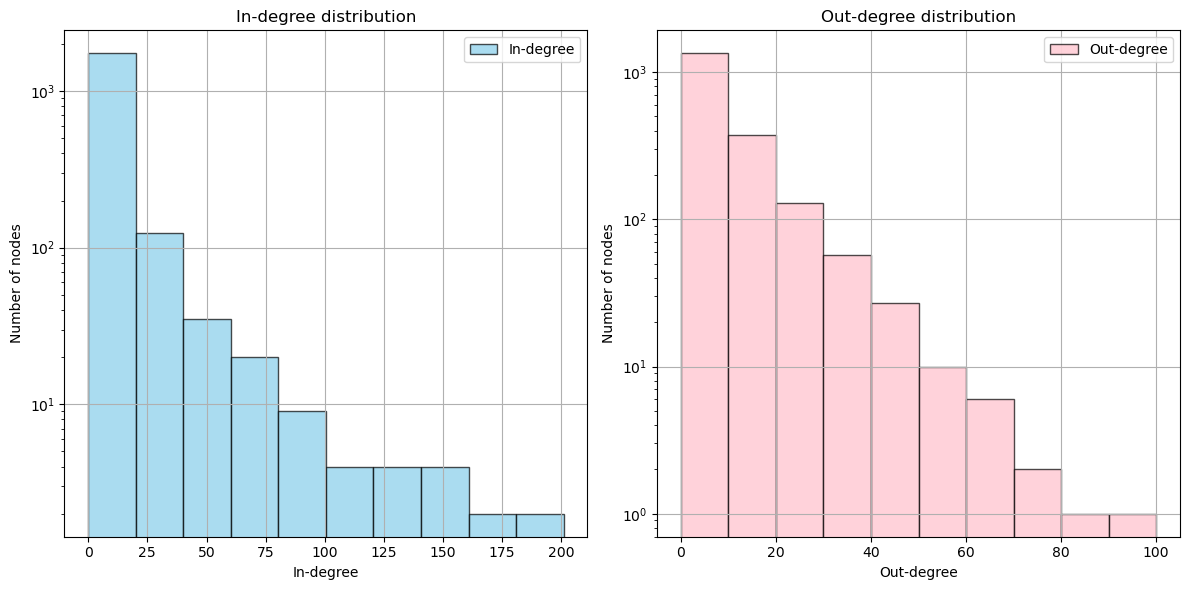

In [25]:
# plot in and out degree distribution

degrees_in = dict(largest_artist.in_degree())
degrees_out = dict(largest_artist.out_degree())

# Plot in-degree distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(list(degrees_in.values()), alpha=0.7, label="In-degree", log=True, color="skyblue", edgecolor="black")
plt.xlabel("In-degree")
plt.ylabel("Number of nodes")
plt.title("In-degree distribution")
plt.legend()
plt.grid(True)

# Plot out-degree distribution
plt.subplot(1, 2, 2)
plt.hist(list(degrees_out.values()), alpha=0.7, label="Out-degree", log=True, color="pink", edgecolor="black")
plt.xlabel("Out-degree")
plt.ylabel("Number of nodes")
plt.title("Out-degree distribution")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


The In-degree distribution of the artist network typically follows a power-law pattern, meaning that a few nodes (artists, in this case) have a very high in-degree, while most have a relatively low in-degree, reflecting their popularity and influence. 
In contrast, the Out-degree distribution is more uniform, indicating that the outgoing links from nodes are more evenly spread among them. This means that while some artists are heavily referenced, they may not not collaborate with the other country artists that often.  
Thus, while the in-degrees reflect the reputation and collaborative ties of artists, leading to hubs in the network, the out-degrees reflect personal choices regarding collaborations, which tend to be fewer and more selective. 

>     * Compare the out-degree distribution to a *random network* with the same number of nodes and links.
>     * Compare the in-degree distribution to a *scale-free* network with the same number of nodes.

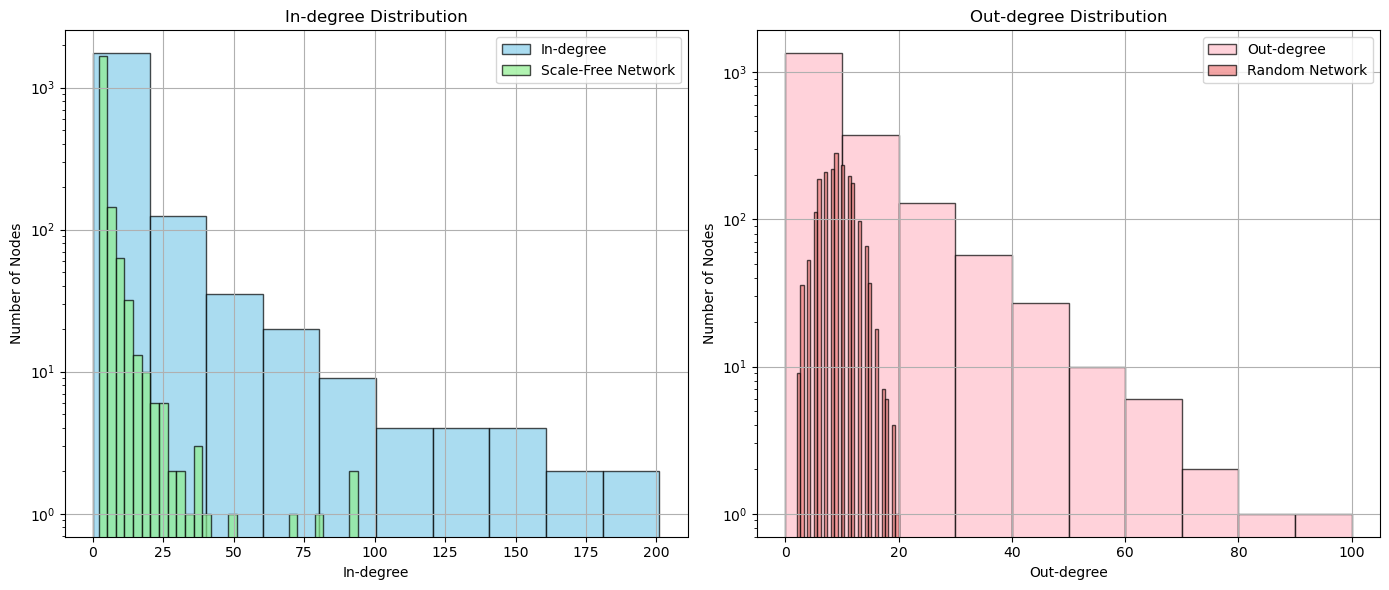

In [26]:
# Create Random Network
num_nodes = largest_artist.number_of_nodes()
num_edges = largest_artist.number_of_edges()
random_network = nx.gnm_random_graph(num_nodes, num_edges, directed=True)
random_degrees_out = dict(random_network.out_degree())
random_degrees_in = dict(random_network.in_degree())

# Create a Directed Scale-Free Network
scale_free_network = nx.barabasi_albert_graph(num_nodes, 2)
# Convert to directed graph
scale_free_network = nx.DiGraph(scale_free_network)
scale_free_degrees_in = dict(scale_free_network.in_degree())
scale_free_degrees_out = dict(scale_free_network.out_degree())

# Plotting
plt.figure(figsize=(14, 6))

# Plot In-Degree Distribution
plt.subplot(1, 2, 1)
plt.hist(list(degrees_in.values()), alpha=0.7, label="In-degree", log=True, color="skyblue", edgecolor="black")
plt.hist(list(scale_free_degrees_in.values()), bins=30, alpha=0.7, label="Scale-Free Network", log=True, color="lightgreen", edgecolor="black")
plt.xlabel("In-degree")
plt.ylabel("Number of Nodes")
plt.title("In-degree Distribution")
plt.legend()
plt.grid(True)

# Plot Out-Degree Distribution
plt.subplot(1, 2, 2)
plt.hist(list(degrees_out.values()), alpha=0.7, label="Out-degree", log=True, color="pink", edgecolor="black")
plt.hist(list(random_degrees_out.values()), bins=30, alpha=0.7, label="Random Network", log=True, color="lightcoral", edgecolor="black")
plt.xlabel("Out-degree")
plt.ylabel("Number of Nodes")
plt.title("Out-degree Distribution")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In a scale-free network, the in-degree distribution often leads to a small number of nodes having very high in-degrees (hubs) while most nodes have a low in-degree. This confirms the previous observations that a few artists dominate the networks in terms of inlfuence, having many incoming links. 

Analysing a random network against the out-degree distribution, we can see that they tend to be more uniform, as every node has an equal chance of connecting to any other node. This behavior is consistent with the properties of a random network, confirming that artists tend to maintain a consistent number of collaborations.


> * Who are the top 5 most connected performers (Report results for in-degrees and out-degrees, that is, who has highest in-degree, who has highest out-degree)? Comment on your findings. Is this what you would have expected?

In [27]:
#top 5 most connected 
# highest in-degree

sorted_in_degree = sorted(degrees_in.items(), key=lambda x: x[1], reverse=True)
print("Top 5 artists by in-degree:")
for artist, degree in sorted_in_degree[:5]:
    print(f"{artist}: {degree}")

print()
# highest out-degree
sorted_out_degree = sorted(degrees_out.items(), key=lambda x: x[1], reverse=True)
print("Top 5 artists by out-degree:")
for artist, degree in sorted_out_degree[:5]:
    print(f"{artist}: {degree}")

Top 5 artists by in-degree:
Willie Nelson: 201
Johnny Cash: 185
Elvis Presley: 175
Dolly Parton: 163
Merle Haggard: 157

Top 5 artists by out-degree:
Hillary Lindsey: 100
Pam Tillis: 82
Randy Travis: 75
Vince Gill: 71
Patty Loveless: 68


The findings reveal a clear distinction between the most connected artists based on in-degree and out-degree. The top artists by in-degree are really popular country artists known by their heavy influence on the genre, suggesting they are frequently referenced by other artists. This reinforces their status as influential hubs in the network. On the other hand, the top artists by out-degree have considerably less connections, but still indicates a high level of collaboration. This suggests that while they may not be as frequently referenced, they play a crucial role in shaping the music of others, possibly as songwriters or active collaborators within the music industry.


> * What are the 10 pages with the longest wiki entries? (use the `length of content` attribute to figure this one out)?


In [28]:
# top 10 longest pages
sorted_word_count = sorted(largest_artist.nodes(data=True), key=lambda x: x[1]['word_count'], reverse=True)
print("Top 10 artists by word count:")
for artist, data in sorted_word_count[:10]:
    print(f"{artist}: {data['word_count']} words")

Top 10 artists by word count:
Beyoncé: 62288 words
Taylor Swift: 56031 words
Miley Cyrus: 51560 words
Justin Bieber: 50696 words
Carrie Underwood: 45290 words
Demi Lovato: 44747 words
Justin Timberlake: 44571 words
Bob Dylan: 41266 words
Ed Sheeran: 36314 words
Elvis Presley: 33795 words


### Let's build a simple visualization of the network
>1. For the sake of the visualisation, let's convert our network to *undirected graph* (tip: There is a NetworkX command to help you).
>   * *Note*: Keep the directed graph, we will use it in couple of the following exercises.

In [29]:
# undirected graph
artists_graph_undirected = largest_artist.to_undirected()

In [30]:
# save graph as a pickle file
import pickle
with open('artists_undirected.gpickle', 'wb') as f:
    pickle.dump(artists_graph_undirected, f, pickle.HIGHEST_PROTOCOL)



>2. Use the NetworkX command `nx.draw_kamada_kawai` to draw the resulting undirected network. (You can find [background on the algorithm here](https://en.wikipedia.org/wiki/Force-directed_graph_drawing).)  
>   * Set up your plot so that node-size depends on the node *degree*.
>   * Make the node color depend on the `length of content` attribute. I recommend choosing a color scheme that is quite simple (e.g. the Sequential ones here: https://matplotlib.org/stable/users/explain/colors/colormaps.html)


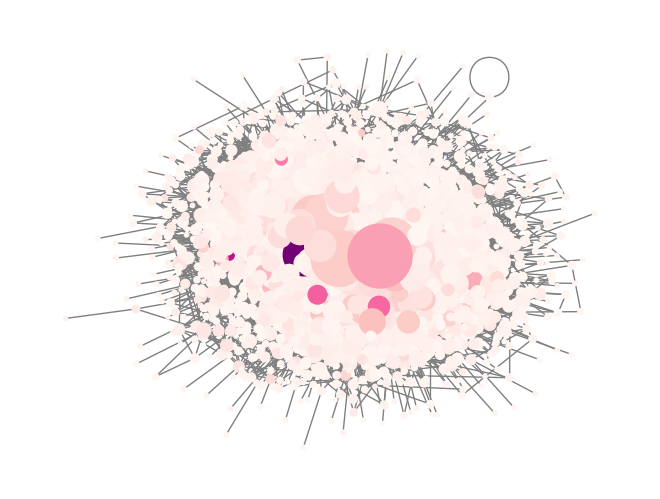

In [72]:
# node size depending on node degree
node_sizes = [v * 10 for v in dict(artists_graph_undirected.degree()).values()]
# node color depending on word count using RdPu colormap
node_colors = [data['word_count'] for _, data in artists_graph_undirected.nodes(data=True)]

nx.draw_kamada_kawai(artists_graph_undirected, node_size=node_sizes, cmap = "RdPu", node_color=node_colors, edge_color='gray')

The network visualization is dense and chaotic, reflecting the complex and numerous connections between artists in the country music world. While it's challenging to draw specific conclusions from this plot, we can observe that many less-connected nodes tend to have fewer words in their Wikipedia entries. Conversely, the highly connected nodes often feature more extensive Wikipedia content, which aligns with our expectations of their popularity and influence in the genre.
Additionally, the presence of self-connected nodes suggests that some artists' Wikipedia pages link back to themselves, possibly indicating that they write their own songs or have a significant amount of personal content.
Moreover, the big difference between node sizes and colors further reinforces the diversity within the network, while the compactness of the plot highlights the interconnectedness of artists.

### References

Barabási, A.L., Albert, R. (1999). *Emergence of Scaling in Random Networks*

Barabási, A. L. (2013). *Network science.* Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 371(1987), 20120375.

Eom, YH., Jo, HH. (2014). *Generalized friendship paradox in complex networks: The case of scientific collaboration.* Sci Rep 4, 4603. https://doi.org/10.1038/srep04603

Cantwell, G. T. ,Kirkley, A., Newman, M. E. J. (April 2021), *The friendship paradox in real and model networks*. Journal of Complex Networks, Volume 9, Issue 2, cnab011. https://doi.org/10.1093/comnet/cnab011